In [1]:
import os
import torch
import gc
import requests
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from transformers import pipeline, BertTokenizer, set_seed, BertForSequenceClassification, Trainer, TrainingArguments, BlipProcessor, BlipForConditionalGeneration, DetrImageProcessor, DetrForObjectDetection
from PIL import Image, ImageDraw
from diffusers import DiffusionPipeline
from huggingface_hub import login
from datasets import Dataset

2025-02-20 18:57:58.385209: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 18:57:58.392741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 18:57:58.401802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 18:57:58.404476: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 18:57:58.411931: I tensorflow/core/platform/cpu_feature_guar

In [2]:
if tf.config.list_physical_devices('GPU'):
    print("¡GPU encontrada!")
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("¡GPU no encontrada!")

¡GPU encontrada!
Num GPUs Available:  1


I0000 00:00:1740074285.603291    6953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740074285.604153    6953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740074285.604247    6953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [10]:
tf.config.set_visible_devices([], 'GPU')

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Crecimiento de memoria configurado para las GPUs.")
    except RuntimeError as e:
        print(f"Error al configurar crecimiento de memoria: {e}")

Crecimiento de memoria configurado para las GPUs.


# EJERCICIOS

## EJERCICIO 1
Utiliza un modelo preentrenado de Hugging Face que clasifique textos en neutral y subjetivo y clasifica las siguientes opiniones:

* "I think the new city park is a great addition to the neighborhood. It offers a lot of green space and is a great place for families to spend time outdoors."

* "The customer service at the restaurant was disappointing. We had to wait over an hour just to get our drinks, and the staff seemed uninterested in helping us."

* "This book is just okay. It's not the best I've read, but it's not the worst either. The plot is somewhat predictable, but the characters are somewhat interesting."

* "The local library has extended its operating hours on weekends. It is now open from 9 a.m. to 7 p.m. on Saturdays and Sundays"

El resultado lo tiene que mostrar  de la siguiente forma:

* Texto: XXX 
* Clasificación: Y con una confianza del X%

In [5]:
model_name = "alexandrainst/da-subjectivivity-classification-base"
#classifier_subje = pipeline("text-classification", model=model_name, device=-1) #CPU
classifier_subje = pipeline("text-classification", model=model_name) #GPU


/home/iabd/anaconda3/envs/Venv6_3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
frases=[
    "I think the new city park is a great addition to the neighborhood. It offers a lot of green space and is a great place for families to spend time outdoors.",
    "The customer service at the restaurant was disappointing. We had to wait over an hour just to get our drinks, and the staff seemed uninterested in helping us.",
    "This book is just okay. It's not the best I've read, but it's not the worst either. The plot is somewhat predictable, but the characters are somewhat interesting.",
    "The local library has extended its operating hours on weekends. It is now open from 9 a.m. to 7 p.m. on Saturdays and Sundays"
]

for frase in frases:
    predict=classifier_subje(frase)
    print(predict)


[{'label': 'objective', 'score': 0.999790608882904}]
[{'label': 'objective', 'score': 0.9819164872169495}]
[{'label': 'subjective', 'score': 0.999299168586731}]
[{'label': 'objective', 'score': 0.9990546107292175}]


## EJERCICIO 2
Traduce el siguiente texto del inglés al español usando un modelo preentrenado de Hugging Face: "The achievements of artificial intelligence are impressive."

In [7]:
model_name = "Helsinki-NLP/opus-mt-en-es"
#modelo_traductor = pipeline("translation", model=model_name, device=-1) #CPU
modelo_traductor = pipeline("translation", model=model_name) #GPU

/home/iabd/anaconda3/envs/Venv6_3/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [8]:
frase = "The achievements of artificial intelligence are impressive."
traducc = modelo_traductor(frase)
print(traducc[0]['translation_text'])


Los logros de la inteligencia artificial son impresionantes.


## EJERCICIO 3
Genera un texto continuando la siguiente frase: "Los logros de la inteligencia artificial..."

Usa gpt2

In [9]:
model_name = "mrm8488/spanish-gpt2"
generator = pipeline("text-generation", model=model_name) #GPU

In [10]:
set_seed(17)

generator("Los logros de la inteligencia artificial", max_length=50, truncation=True, num_return_sequences=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Los logros de la inteligencia artificial que los dos científicos y sus colegas del Laboratorio de Inteligencia Artificial de la Universidad de Cornell demostraron es que, como con cualquier inteligencia artificial, la tecnología para construir a los robots que son usados no puede ser desarrollada o limitada'}]

Los logros de la inteligencia artificial que los dos científicos y sus colegas del Laboratorio de Inteligencia Artificial de la Universidad de Cornell demostraron es que, como con cualquier inteligencia artificial, la tecnología para construir a los robots que son usados no puede ser desarrollada o limitada

## EJERCICIO 4
Entrena un modelo de análisis de sentimientos en un pequeño conjunto de datos personalizado usando un modelo de Hugging Face. Supongamos que tienes el siguiente conjunto de datos (evidentemente con este conjunto de datos tan pequeño no vamos a ningún lado, se trata de simular el proceso):

* "I enjoy playing football.", Positivo
* "The restaurant had poor service.", Negativo
* "Such a beautiful day outside!", Positivo

Si quieres puedes usar el modelo bert-base-uncased

Los pasos generales que puedes seguir son:
* Prepara los datos de entrenamiento (X e y).
* Carga un modelo preentrenado de Transformers y su tokenizador.
* Preprocesa los datos para que sean compatibles con el modelo.
* Compila el modelo con una función de pérdida y un optimizador.
* Entrena el modelo con los datos.
* Evalúa el modelo con algunos datos ("I enjoy playing basketboall.", Positivo y "I hate rainning days.", Negativo).
* Predice nuevos datos ("The restaurant had a good service.")

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

In [12]:
data = {
    'text': ["I enjoy playing football.", "The restaurant had poor service.", "Such a beautiful day outside!"],
    'label': [1, 0, 1]  # Etiquetas codificadas
}
dataset = Dataset.from_dict(data)

# Tokenizar el dataset
dataset = dataset.map(tokenize_function, batched=True)
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
val_dataset = train_test_split["test"]

Map: 100%|██████████| 3/3 [00:00<00:00, 573.67 examples/s]


In [13]:
# Cargar el modelo preentrenado
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Directory to store results
    num_train_epochs=3,              # Number of epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps
    weight_decay=0.01,               # Weight decay
    logging_dir='./logs',            # Directory for logs
    logging_steps=10,
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save model at the end of each epoch
    load_best_model_at_end=True     # Load the best model at the end of training
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Save the model
trainer.save_model("./final_model")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/iabd/anaconda3/envs/Venv6_3/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 33%|███▎      | 1/3 [00:13<00:26, 13.43s/it]OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this

{'eval_loss': 1.2060186862945557, 'eval_runtime': 3.0339, 'eval_samples_per_second': 0.33, 'eval_steps_per_second': 0.33, 'epoch': 1.0}


 67%|██████▋   | 2/3 [00:28<00:14, 14.64s/it]OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with 

{'eval_loss': 1.2057926654815674, 'eval_runtime': 3.7341, 'eval_samples_per_second': 0.268, 'eval_steps_per_second': 0.268, 'epoch': 2.0}


100%|██████████| 3/3 [00:44<00:00, 15.10s/it]OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with 

{'eval_loss': 1.2053594589233398, 'eval_runtime': 3.2639, 'eval_samples_per_second': 0.306, 'eval_steps_per_second': 0.306, 'epoch': 3.0}


100%|██████████| 3/3 [00:50<00:00, 16.77s/it]


{'train_runtime': 50.3244, 'train_samples_per_second': 0.119, 'train_steps_per_second': 0.06, 'train_loss': 0.7900827725728353, 'epoch': 3.0}


In [14]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

In [15]:
texts = [
    "I love playing basketball.",
    "I hate rainning days."
]

# Crear un dataset con las frases
test_dataset = Dataset.from_dict({"text": texts}).map(preprocess_function, batched=True)

# Asegurar que el dataset tenga el formato correcto
test_dataset = test_dataset.remove_columns(["text"])  # Trainer espera solo tensores

# Hacer la predicción
predictions = trainer.predict(test_dataset)

# Convertir logits a etiquetas de clase
predicted_classes = torch.tensor(predictions.predictions).argmax(dim=-1)
print(predicted_classes.tolist())  # Lista de clases predichas
print(predictions)

100%|██████████| 1/1 [00:00<00:00, 2461.45it/s]

[0, 0]
PredictionOutput(predictions=array([[ 0.48920915, -0.35629642],
       [ 0.4996689 , -0.37547374]], dtype=float32), label_ids=None, metrics={'test_runtime': 1.014, 'test_samples_per_second': 1.972, 'test_steps_per_second': 0.986})


In [31]:
# Clases del modelo (ajústalas según tu dataset)
class_labels = ["Negative", "Positive"]  # Suponiendo 0 = Negativo, 1 = Positivo

# Extraer predicciones
logits = predictions.predictions  # Obtener logits
predicted_classes = torch.tensor(logits).argmax(dim=-1).tolist()  # Convertir a etiquetas

# Formatear salida
print("\nPredicciones:")
for text, pred in zip(texts, predicted_classes):
    print(f"Texto: {text}\n → Predicción: {class_labels[pred]}\n")


Predicciones:
Texto: I love playing basketball.
 → Predicción: Negative

Texto: I hate rainning days.
 → Predicción: Negative



## EJERCICIO 5
Utiliza un modelo preentrenado de Hugging Face para generar una descripción (caption) para una imagen dada.

/home/iabd/anaconda3/envs/Venv6_3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


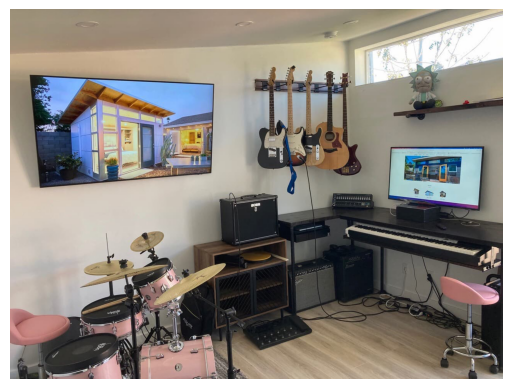

/home/iabd/anaconda3/envs/Venv6_3/lib/python3.12/site-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a photography of a home studio with a guitar, drums, and a monitor
a room with a desk, guitar, and a monitor


In [17]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Cargar la imagen
raw_image = "/home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/imagenes/estudio.jpg"
img = Image.open(raw_image)

# Mostrar la imagen con matplotlib
plt.imshow(img)
plt.axis('off')  # Opcional: quita los ejes para una mejor visualización
plt.show()

# Conditional image captioning
text = "a photography of"

# Pasar la imagen cargada 'img' en lugar de la ruta
inputs = processor(img, text, return_tensors="pt")

# Generar la predicción
out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# Unconditional image captioning
inputs = processor(img, return_tensors="pt")

# Generar la predicción
out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

## EJERCICIO 6
Elige un modelo de detcción de objetos de Hugging Face y aplícalo a una imagen.

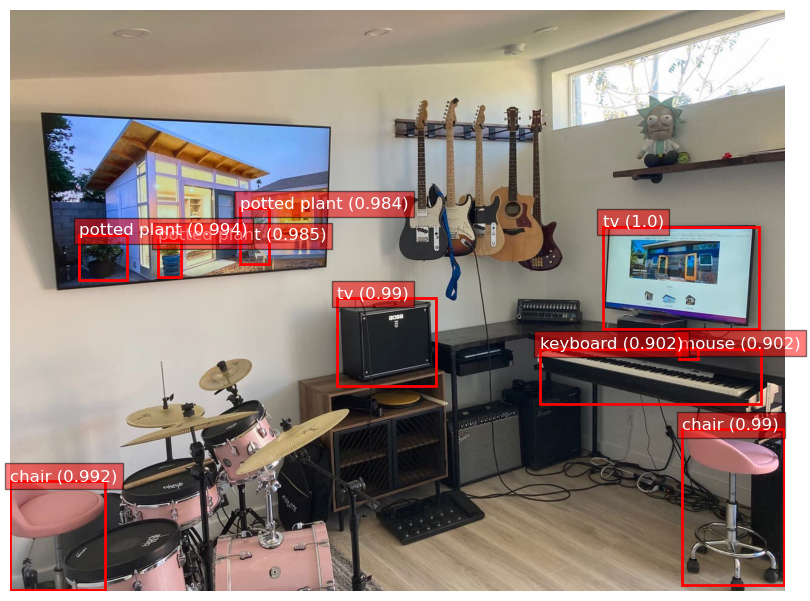

In [4]:
# Inicializar el procesador y el modelo
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

# Cargar la imagen
image_path = "/home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/imagenes/estudio.jpg"
image = Image.open(image_path)

# Procesar la imagen y obtener las predicciones
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# Convertir las salidas (cajas delimitadoras y logits de clase) a la API COCO
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

# Mostrar la imagen con Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(image)

# Dibujar los recuadros sobre la imagen
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, xmax, ymax = box
    width, height = xmax - x, ymax - y
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
    label_name = model.config.id2label[label.item()]
    text = f"{label_name} ({round(score.item(), 3)})"
    ax.text(x, y, text, fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()


## EJERCICIO 7
Genera un texto usando un modelo de generción de texto (gpt2).
Usa el texto creado como entrada para un modelo de generación de imágenes (stable-diffusion).

El texto de entrada para el primer modelo va a ser

/home/iabd/anaconda3/envs/Venv6_3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

Prompt generado: A monkey with a bad haircut was walking around the


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


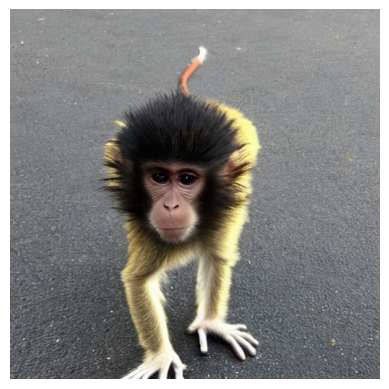

In [3]:
# %conda env config vars set OPENBLAS_NUM_THREADS=1

# Cargar el modelo de texto GPT-2
text_generator = pipeline("text-generation", model="gpt2-medium")

# Generar prompt de imagen con GPT-2
input_text = "A monkey"
generated_prompt = text_generator(input_text, max_length=10, temperature=0.7, repetition_penalty=1.5, top_k=50, top_p=0.9, eos_token_id=50256)[0]['generated_text']

print("Prompt generado:", generated_prompt)

# Cargar el modelo de Stable Diffusion
sd_pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
sd_pipeline.to("cuda")

# Generar imagen con el prompt de GPT-2
image = sd_pipeline(generated_prompt).images[0]

# Guardar imagen

plt.imshow(image)
plt.axis('off')  # Opcional: quita los ejes para una mejor visualización
plt.show()

## EJERCICIO 8 (OPCIONAL)
Encadena con sentido tres modelos de Hugging Face para realizar una tarea de NLP, una de visión y una de generación de imágenes.

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt generado: A RatRoach
 (Rat) - 6.5" tall, 5-piece construction


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


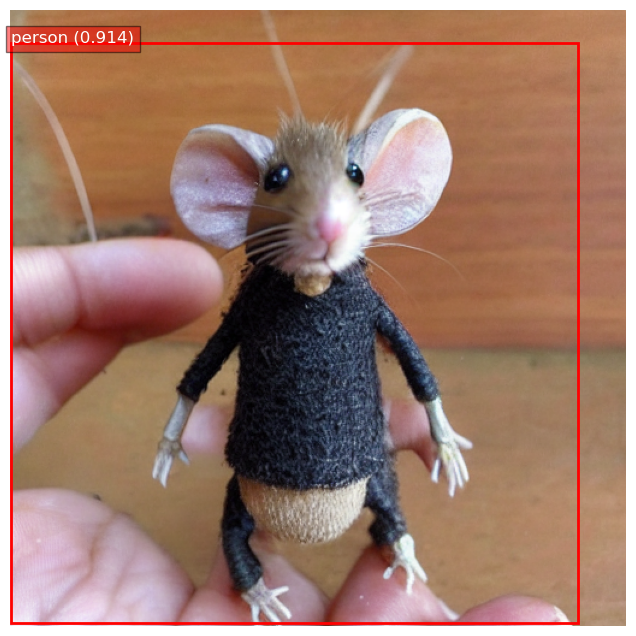

In [11]:
# %conda env config vars set OPENBLAS_NUM_THREADS=1

# Cargar el modelo de texto GPT-2
text_generator = pipeline("text-generation", model="gpt2-medium")

# Generar prompt de imagen con GPT-2
input_text = "A RatRoach"
generated_prompt = text_generator(input_text, max_length=20, temperature=0.7, repetition_penalty=1.5, top_k=50, top_p=0.9, eos_token_id=50256)[0]['generated_text']

print("Prompt generado:", generated_prompt)

# Cargar el modelo de Stable Diffusion
sd_pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
sd_pipeline.to("cuda")

# Generar imagen con el prompt de GPT-2
image = sd_pipeline(generated_prompt).images[0]

# Guardar imagen

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

# Procesar la imagen y obtener las predicciones
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# Convertir las salidas (cajas delimitadoras y logits de clase) a la API COCO
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

# Mostrar la imagen con Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(image)

# Dibujar los recuadros sobre la imagen
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, xmax, ymax = box
    width, height = xmax - x, ymax - y
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
    label_name = model.config.id2label[label.item()]
    text = f"{label_name} ({round(score.item(), 3)})"
    ax.text(x, y, text, fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()